In [89]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

from itertools import repeat
from torch.multiprocessing import Pool
import time

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=10, force_steps = 5, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        #obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, mdim_policy, init_state, force)    
    
    return None, np.asarray(obs)

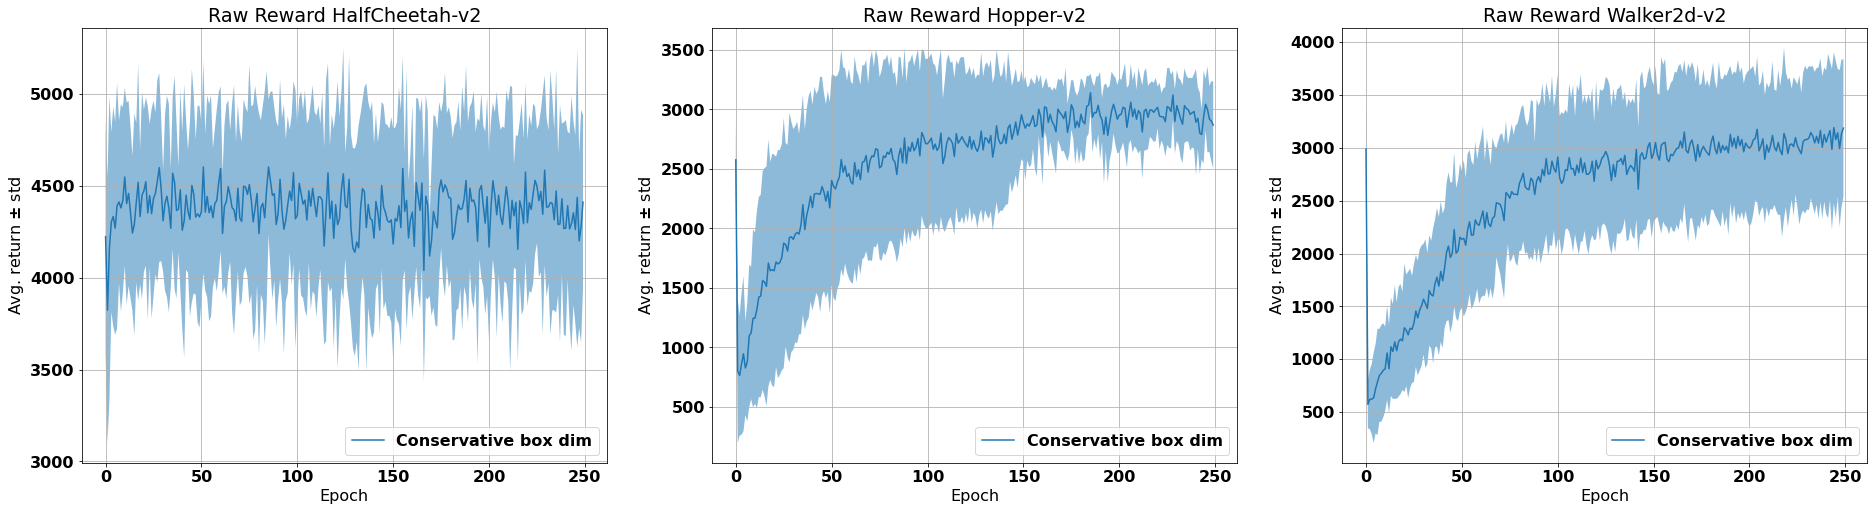

In [2]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    #init_data = torch.load(f"./data17/{env_name}.xr")
    init_data = torch.load(f"./data_noise1/{env_name}.xr")

    init_policy_dict = init_data.policy_dict
    
    #data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    data = torch.load(f"./data_noise1_mdim/{env_name}.xr")

    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()

In [79]:
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,3,4,5,6]
# rollout_length = 1000
# lookback_length = 50

#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 100
# lookback_length = 5

# def fail_cond(ob):
#     return not (-.25 < ob[1] < .25)

#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    tilted = np.abs(obs[:,1]) > .2 
    short = obs[:,0] < .7
    return np.logical_or(tilted, short)

seeds = [0,1,2,3,4,5,6,7,8,9]
# ===============================


env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

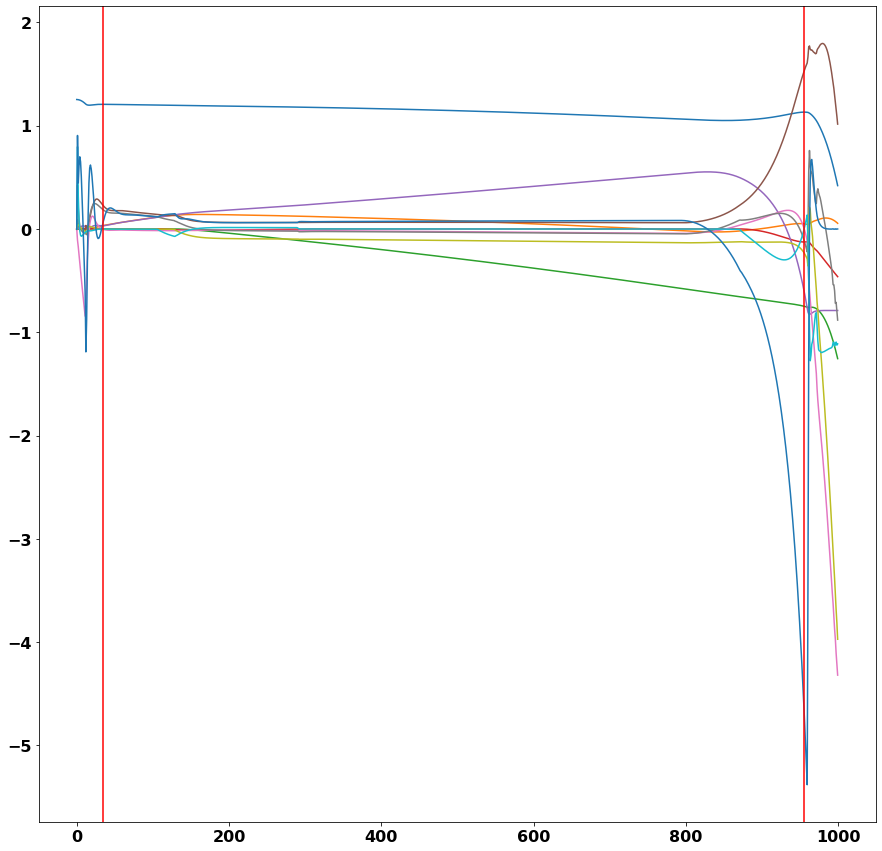

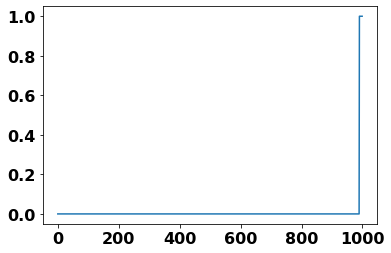

In [84]:
policy = policy_dict['identity'][0]
obs, acts, rews, _ = do_long_rollout(env, policy, ep_length=1000)


plt.subplots(1,figsize=(15,15))
plt.plot(obs)

from scipy.signal import find_peaks

peak_idx,_ = find_peaks(obs[:,0], distance=20)

for i in peak_idx:
    plt.axvline(x=i, color='r')

plt.figure()
plt.plot(fail_cond(obs))
    

# Construct Initial Mesh

478

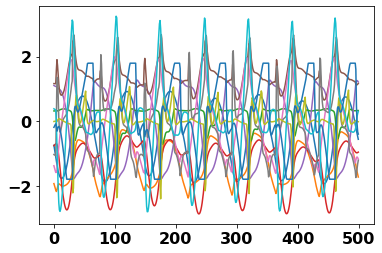

In [90]:
from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq, trans_list):
        self.state = state
        self.id = iden
        self.freq = freq
        self.trans_list = trans_list

seed = 0; delta = .2;

iden_policy = policy_dict[post_names[0]][seed]
mdim_policy = policy_dict[post_names[0]][seed]

iden_mesh = BoxMesh(delta); iden_l = []
mdim_mesh = BoxMesh(delta); mdim_l = []


fail_state = np.ones_like(env.reset())*100
fail_id = 0
mdim_mesh[fail_state] = MeshBox(fail_state, 0, 1, [])

batch_size = 128

iden_obs, iden_acts, iden_rews, _ = do_rollout(env,iden_policy)
mdim_obs, mdim_acts, mdim_rews, _ = do_rollout(env,mdim_policy)
            
for o in iden_obs:
    if o in iden_mesh:
        iden_mesh[o].freq += 1
    else:
        iden_mesh[o] = MeshBox(o, len(iden_mesh), 1, [])

        
mdim_obs = (mdim_obs - mdim_policy.state_means)/mdim_policy.state_std
for o in mdim_obs[500:]:
    if o in mdim_mesh:
        mdim_mesh[o].freq +=1
    else:
        mdim_mesh[o] =  MeshBox(o, len(mdim_mesh), 1, [])
        
        
plt.plot(mdim_obs[500:]);
len(mdim_mesh)

In [91]:
start = time.time()
keys = list(mdim_mesh.keys())
i = 0 
with Pool(12) as pool:
    for key in keys:    
        i+=1 
        
        init_state = mdim_mesh[key].state*np.asarray(mdim_policy.state_std) + np.asarray(mdim_policy.state_means)
        forces = np.linspace(-1,1,3)
        force_iter = [np.array([force,0]) for force in forces]
        state_iter = repeat(init_state, batch_size)
        seeds_iter = range(i*batch_size, i*batch_size+batch_size)

    
        for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
            _ , mdim_obs = res
            
            mdim_obs = mdim_obs[-1,:]
            
            mdim_key = (np.array(mdim_obs) - mdim_policy.state_means)/mdim_policy.state_std
            
            if mdim_key in mdim_mesh:
                new_id = mdim_mesh[mdim_key].id
                mdim_mesh[mdim_key].freq += 1
            else:
                if fail_cond(mdim_obs):
                    new_id = fail_id
                    mdim_mesh[fail_state].freq +=1
                else:
                    mdim_mesh[mdim_key] = MeshBox(mdim_obs, len(mdim_mesh), 1, [])
                    new_id = len(mdim_mesh)
                    keys.append(mdim_mesh.__keytransform__(mdim_key))
            
            mdim_mesh[key].trans_list.append(new_id)
                        
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

TypeError: rsub() received an invalid combination of arguments - got (Tensor, numpy.ndarray), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha)
 * (Tensor input, Number other, Number alpha)


# Construct and Populate Transition Matrix

In [37]:
from scipy.sparse import lil_matrix
T = lil_matrix((len(mdim_mesh)+2, len(mdim_mesh)+2))

for box in mdim_mesh.values():
    for trans_id in box.trans_list:
        T[box.id, trans_id] += 1/len(box.trans_list)

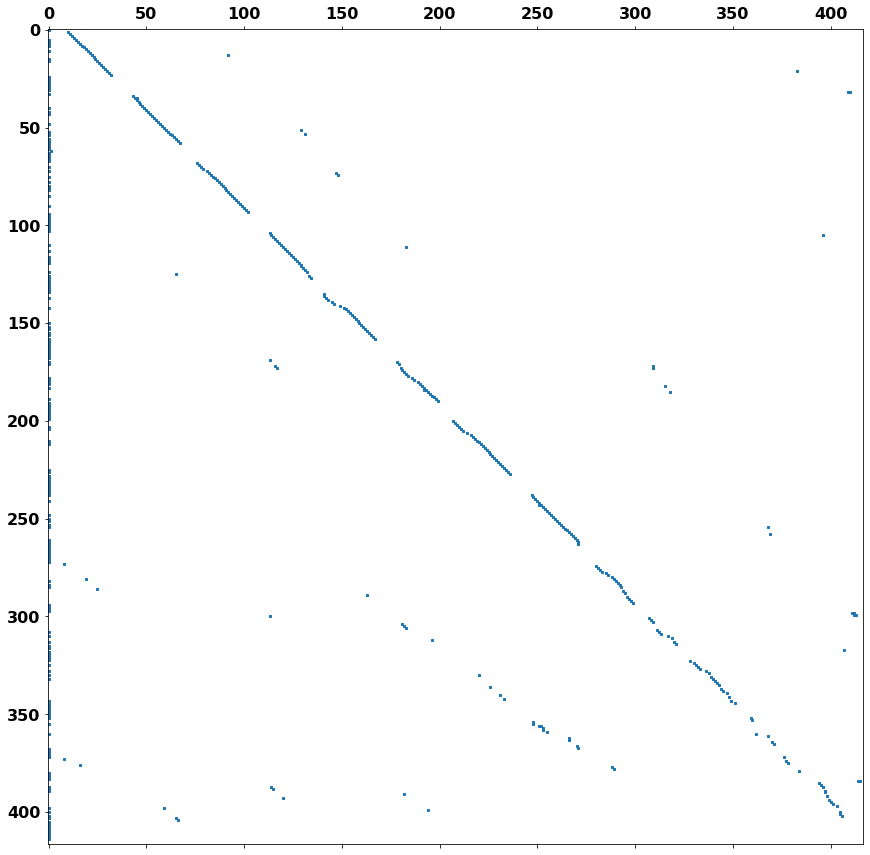

In [38]:
#plt.spy(T, markersize=4, figsize=(15,20))

fig, ax = plt.subplots(1, figsize=(15,15))

ax.spy(T, markersize=2)

In [24]:
from scipy.sparse.linalg import eigs
w, v = eigs(T)
print(w)

[ 1.        +0.j          0.01249959+0.00454814j  0.01249959-0.00454814j
 -0.01019365+0.00855805j -0.01019365-0.00855805j -0.01331261+0.j        ]


In [ ]:
for m in mdim_mesh.values():
    print(m)